<a href="https://colab.research.google.com/github/JanryPei/UAP/blob/main/UAP_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Input = 1 * 28 * 28
        # Output = 16 * 28 * 28
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.batch1 = nn.BatchNorm2d(16)
        # Input = 16 * 28 *28
        # Output = 16 * 28 * 28
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        # Input = 16 * 28 * 28
        # Output = 16 * 28 *28
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.batch3 = nn.BatchNorm2d(16)
        # Input = 16 * 28 * 28
        # Output = 16 * 14 * 14
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input = 16 * 14 * 14
        # Output = 32 * 14 * 14
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.batch4 = nn.BatchNorm2d(32)
        # Input = 32 * 14 * 14
        # Output = 32 * 14 * 14
        self.conv5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch5 = nn.BatchNorm2d(32)
        # Input = 32 * 14 * 14
        # Output = 32 * 14 *14
        self.conv6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.batch6 = nn.BatchNorm2d(32)
        # Input = 32 * 14 *14
        # Output = 32 * 7 * 7
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input = 32 * 7 * 7
        # Output = 48 * 5 * 5
        self.conv7 = nn.Conv2d(32, 48, kernel_size=3)
        self.batch7 = nn.BatchNorm2d(48)

        # Input = 48 * 5 * 5
        # Output= 32 * 5 * 5
        self.conv8 = nn.Conv2d(48, 32, kernel_size=1)
        self.batch8 = nn.BatchNorm2d(32)

        # Input = 32 * 5 * 5
        # Output= 16 * 5 * 5
        self.conv9 = nn.Conv2d(32, 16, kernel_size=1)
        self.batch9 = nn.BatchNorm2d(16)

        self.pool3 = nn.AvgPool2d(5)

        self.fc1 = nn.Linear(1 * 1 * 16, 10)


    def forward(self,x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = F.relu(x)

        x = self.pool1(x)

        x = self.conv4(x)
        x = self.batch4(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.batch5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.batch6(x)
        x = F.relu(x)

        x = self.pool2(x)

        x = self.conv7(x)
        x = self.batch7(x)
        x = F.relu(x)

        x = self.conv8(x)
        x = self.batch8(x)
        x = F.relu(x)

        x = self.conv9(x)
        x = self.batch9(x)
        x = F.relu(x)

        x = self.pool3(x)

        x = x.reshape(-1, 16)
        x = self.fc1(x)
        return x

# data

In [4]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),  # Transform to tensor
        transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
    ])

    data_dir = './dataset/'
    print('Data stored in %s' % data_dir)
    trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
    testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=10, shuffle=False)
    return trainloader, testloader


# deepfool

In [5]:
def zero_gradients(x):
    if x.grad is not None:
        x.grad.zero_()


def deepfool(image, net, num_classes, overshoot, max_iter):
    """
       :param image:
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """

    is_cuda = torch.cuda.is_available()
    if is_cuda:
        image = image.cuda()
        net = net.cuda()

    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = f_image.argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k) / np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i = (pert + 1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1 + overshoot) * torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1 + overshoot) * torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        # print(image.shape)
        # print(x.view(1,1,image.shape[0],-1).shape)
        fs = net.forward(x.view(1, 1, image.shape[1], -1))
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    return (1 + overshoot) * r_tot, loop_i, label, k_i, pert_image

# generate perturbation

In [6]:
def project_perturbation(data_point, p, perturbation):
    if p == 2:
        perturbation = perturbation * min(1, data_point / np.linalg.norm(perturbation.flatten(1)))
    elif p == np.inf:
        perturbation = np.sign(perturbation) * np.minimum(abs(perturbation), data_point)
    return perturbation

In [29]:
def generate(accuracy, trainset, testset, net, delta=0.07, max_iter_uni=np.inf, xi=10, p=np.inf, num_classes=10,
             overshoot=0.2, max_iter_df=20):
    '''
    :param trainset: Pytorch Dataloader with train data
    :param testset: Pytorch Dataloader with test data
    :param net: Network to be fooled by the adversarial examples
    :param delta: 1-delta represents the fooling_rate, and the objective
    :param max_iter_uni: Maximum number of iterations of the main algorithm
    :param p: Only p==2 or p==infinity are supported
    :param num_class: Number of classes on the dataset
    :param overshoot: Parameter to the Deep_fool algorithm
    :param max_iter_df: Maximum iterations of the deep fool algorithm
    :return: perturbation found (not always the same on every run of the algorithm)
    '''

    net.eval()
    device = 'cpu'

    # Importing images and creating an array with them
    img_trn = []
    for image in trainset:
        for image2 in image[0]:
            img_trn.append(image2.numpy())

    img_tst = []
    for image in testset:
        for image2 in image[0]:
            img_tst.append(image2.numpy())

    # Setting the number of images to 300  (A much lower number than the total number of instances on the training set)
    # To verify the generalization power of the approach
    num_img_trn = 300
    index_order = np.arange(num_img_trn)

    # 图片处理
    transformer = transforms.ToTensor()
    transformer1 = transforms.Compose([
        transforms.ToTensor(),
    ])
    transformer2 = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(28), # 中心裁切
    ])

    # 初始化扰动、愚弄率及迭代次数
    v = np.zeros([28, 28])
    fooling_rate = 0.0
    iteration = 0
    fooling_rates = [0]
    accuracies = []
    accuracies.append(accuracy)
    total_iterations = [0]
    # Begin of the main loop on Universal Adversarial Perturbations algorithm
    while fooling_rate < 1 - delta and iteration < max_iter_uni:
        np.random.shuffle(index_order)
        print("Iteration  ", iteration)

        # 训练每一张图片
        for index in index_order:
            v = v.reshape((v.shape[0], -1))

            # 原始图像
            cur_img = Image.fromarray(img_trn[index][0])
            cur_img1 = transformer1(transformer2(cur_img))[np.newaxis, :].to(device)
            r2 = (net(cur_img1).max(1)[1])
            torch.cuda.empty_cache()

            # 扰动图像
            per_img = Image.fromarray(transformer2(cur_img) + v.astype(np.uint8))
            per_img1 = transformer1(transformer2(per_img))[np.newaxis, :].to(device)
            r1 = (net(per_img1).max(1)[1])
            torch.cuda.empty_cache()

            # 若标签相同则更新扰动
            if r1 == r2:
                print(">> k =", np.where(index == index_order)[0][0], ', pass #', iteration, end='      ')
                # 找到愚弄该图像的最小扰动
                dr, iter_k, label, k_i, pert_image = deepfool(per_img1[0], net, num_classes=num_classes,
                                                                       overshoot=overshoot, max_iter=max_iter_df)

                # 加入新发现的扰动，并将扰动v和数据点xi投射到p上。
                if iter_k < max_iter_df - 1:
                    v[:, :] += dr[0, 0, :, :]

                    v = project_perturbation(xi, p, v)

        iteration = iteration + 1

        # Reshaping v to the desired shape
        v = v.reshape((v.shape[0], -1, 1))

        with torch.no_grad():

            # Compute fooling_rate
            labels_original_images = torch.tensor(np.zeros(0, dtype=np.int64))
            labels_pertubed_images = torch.tensor(np.zeros(0, dtype=np.int64))

            i = 0
            # Finding labels for original images
            for batch_index, (inputs, _) in enumerate(testset):
                i += inputs.shape[0]
                inputs = inputs.to(device)
                outputs = net(inputs)
                _, predicted = outputs.max(1)
                labels_original_images = torch.cat((labels_original_images, predicted.cpu()))
            torch.cuda.empty_cache()
            correct = 0
            # Finding labels for perturbed images
            for batch_index, (inputs, labels) in enumerate(testset):
                inputs = inputs.to(device)
                inputs += transformer(v).float()
                outputs = net(inputs)
                _, predicted = outputs.max(1)
                labels_pertubed_images = torch.cat((labels_pertubed_images, predicted.cpu()))
                correct += (predicted == labels).sum().item()
            torch.cuda.empty_cache()

            # Calculating the fooling rate by dividing the number of fooled images by the total number of images
            fooling_rate = float(torch.sum(labels_original_images != labels_pertubed_images)) / float(i)

            print()
            print("FOOLING RATE: ", fooling_rate)
            fooling_rates.append(fooling_rate)
            accuracies.append(correct / i)
            total_iterations.append(iteration)

    return v, fooling_rates, accuracies, total_iterations


# train

In [32]:
class trainer:
    def __init__(self):
        self.net = ConvNet()
        self.net.to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=0.01)
        self.n_epochs = 10

    def train(self, trainloader, testloader):
        accuracy = 0
        self.net.train()
        for epoch in range(self.n_epochs):
            running_loss = 0.0
            print_every = 200  # mini-batches
            for i, (inputs, labels) in enumerate(trainloader, 0):
                # Transfer to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()
                if (i % print_every) == (print_every - 1):
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / print_every))
                    running_loss = 0.0

            # Print accuracy after every epoch
            accuracy = compute_accuracy(self.net, testloader)
            print('Accuracy of the network on the 60000 test images: %.3f %%' % (100 * accuracy))

        print('Finished Training')
        return accuracy


def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


# start

Data stored in ./dataset/
[1,   200] loss: 0.976
[1,   400] loss: 0.586
[1,   600] loss: 0.504
[1,   800] loss: 0.463
[1,  1000] loss: 0.453
[1,  1200] loss: 0.395
[1,  1400] loss: 0.394
[1,  1600] loss: 0.361
[1,  1800] loss: 0.362
Accuracy of the network on the 60000 test images: 85.990 %
[2,   200] loss: 0.558
[2,   400] loss: 0.380
[2,   600] loss: 0.448
[2,   800] loss: 0.348
[2,  1000] loss: 0.349
[2,  1200] loss: 0.346
[2,  1400] loss: 0.323
[2,  1600] loss: 0.313
[2,  1800] loss: 0.308
Accuracy of the network on the 60000 test images: 88.700 %
[3,   200] loss: 0.312
[3,   400] loss: 0.282
[3,   600] loss: 0.291
[3,   800] loss: 0.291
[3,  1000] loss: 0.288
[3,  1200] loss: 0.282
[3,  1400] loss: 0.287
[3,  1600] loss: 0.297
[3,  1800] loss: 0.281
Accuracy of the network on the 60000 test images: 87.990 %
[4,   200] loss: 0.283
[4,   400] loss: 0.281
[4,   600] loss: 0.276
[4,   800] loss: 0.258
[4,  1000] loss: 0.266
[4,  1200] loss: 0.267
[4,  1400] loss: 0.270
[4,  1600] loss

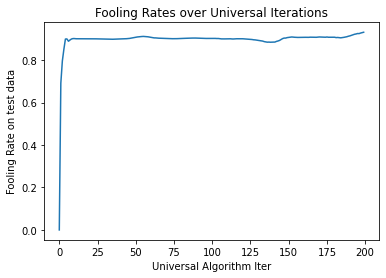

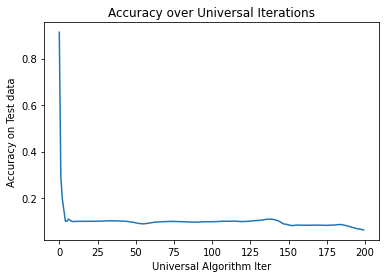

In [33]:
trainer = trainer()
trainset, testset = load_data()
accuracy = trainer.train(trainset, testset)
trainset, testset = load_data()

v, fooling_rates, accuracies, total_iterations = generate(accuracy, trainset, testset, trainer.net)

plt.title("Fooling Rates over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Fooling Rate on test data")
plt.plot(total_iterations, fooling_rates)
plt.show()

plt.title("Accuracy over Universal Iterations")
plt.xlabel("Universal Algorithm Iter")
plt.ylabel("Accuracy on Test data")
plt.plot(total_iterations, accuracies)
plt.show()

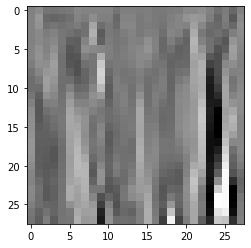

In [28]:
plt.imshow(v.squeeze(), cmap = "gray")